# NNs in an FRTB Framework

## Notebook Setup


In [1]:
# import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle  
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import r2_score
# from scipy.stats import spearmanr
# from scipy.stats import ks_2samp 


from IPython.display import clear_output

# from numpy.linalg import cholesky

In [2]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [3]:
# !rm -r {'PHD_Code'}
# !git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code/CODE')

clear_output()

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/MODELS/"

PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS/"

In [6]:
import Option_formulas
import Miscellanea
import Deep_learning_models
import ModelHandlers
import Scenario_Simulation

In [7]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

## Load Historical Data

In [8]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')

display(hist_data.head(3))
display(hist_data.tail(3))


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2010-01-01,7.526,37.458,125.0310,23.275,41.67,35.088
2010-01-04,7.643,37.428,126.5115,23.198,42.85,34.045
2010-01-05,7.656,38.004,124.9832,23.318,43.68,33.323


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2022-12-06,142.91,34.215,147.50,24.998,131.59,29.305
2022-12-07,140.94,34.771,147.27,25.134,131.50,29.658
2022-12-08,140.94,34.771,147.27,25.134,131.50,29.658


## Computation of 1d and 10d schocks

In [9]:
risk_horizon = 10
hist_data_length = 250

hist_schocks_10d = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns) 

hist_schocks_10d = hist_schocks_10d.iloc[-hist_data_length:]

hist_schocks_1d = pd.DataFrame(data = np.log(hist_data.iloc[1:].values/ hist_data.iloc[0:-1].values),
                            index =  hist_data.index[1:], columns = hist_data.columns) 

hist_schocks_1d = hist_schocks_1d.iloc[-hist_data_length:]


### Plot historical schocks. 1d / 10d

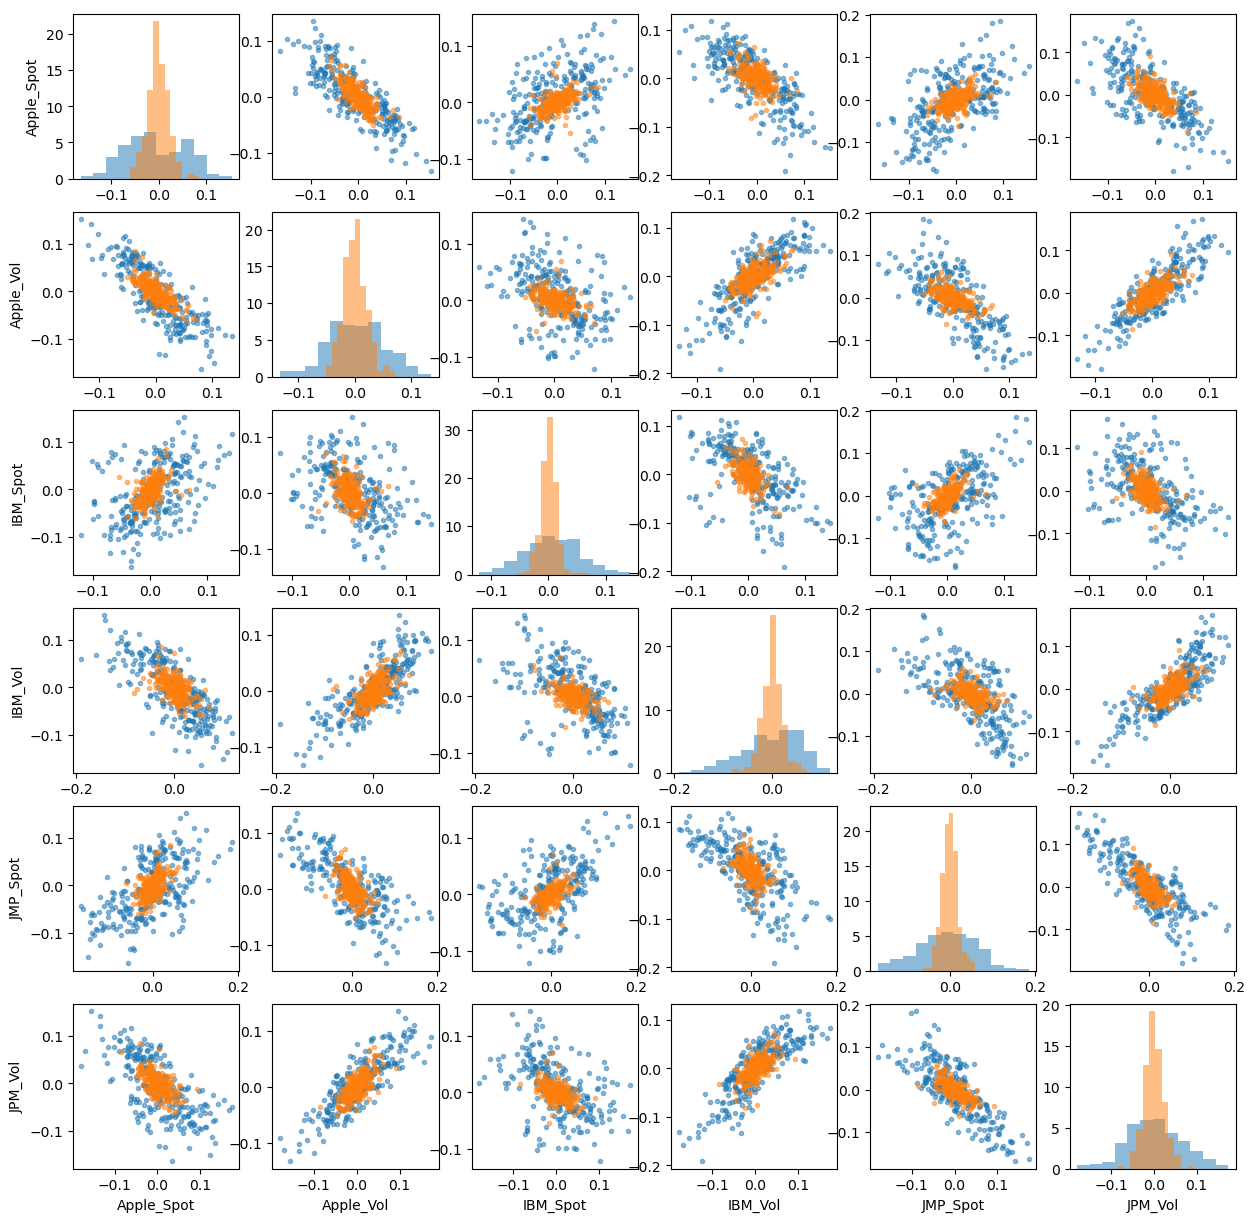

In [10]:
Miscellanea.plot_schocks(6,[hist_schocks_10d.values,hist_schocks_1d.values],hist_schocks_10d.columns,12)  

plt.savefig(PATH_FIGS + 'histdata_1d_10d.pdf')

### Calibrate historical data and generate training data

In [11]:
num_sims_train = 2**16
num_sims_test = 2**14


gaussian_model_dict = dict()
base_scenario_dict = dict()
simulation_dict = dict()
contract_data_dict = dict()


gaussian_model_dict['n_components'] = 6
gaussian_model_dict['gaussian_model_seed'] = 1234

base_scenario_dict['spot_indexes'] = [0,2,4]
base_scenario_dict['spots'] = [1.0,1.0,1.0]
base_scenario_dict['vol_indexes'] = [1,3,5]
base_scenario_dict['vols'] = [0.2,0.3,0.15]
base_scenario_dict['correlations'] = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]
base_scenario_dict['rfr'] = 0.01
base_scenario_dict['divs'] = 0.0

simulation_dict['number_of_scenarios'] = num_sims_train + num_sims_test
simulation_dict['shocks_generation_option'] = Scenario_Simulation.MktRisk_Scenarios_Generation_Option.EXPONENTIAL
simulation_dict['tf_generation_option'] = Scenario_Simulation.Include_Tensorflow_Calcs_option.YES
simulation_dict['simulation_seed'] = 5678
simulation_dict['Simulate_Var_Red_Payoff'] = Scenario_Simulation.Simulate_Var_Red_Payoff.NO

indiv_strikes = [1.0,1.0,1.0]
option_strike = 1.0

contract_data_dict['ttm'] = 3.0
contract_data_dict['payoff'] = lambda spot_t : Scenario_Simulation.basket_option(spot_t, indiv_strikes = indiv_strikes, 
                    option_strike = option_strike, 
                    tf_option = simulation_dict['tf_generation_option'] )


dict_1d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.values)

gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321


dict_10d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

train_data_keys = ['sim_scenario_levels', 'payoff', 'pathwise_derivs'] 

dict_1d_results_train = {k:dict_1d_results[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results[k] for k in train_data_keys}


dict_mixed_data_train = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train


### Plot synthetic data + real data

### 1 days

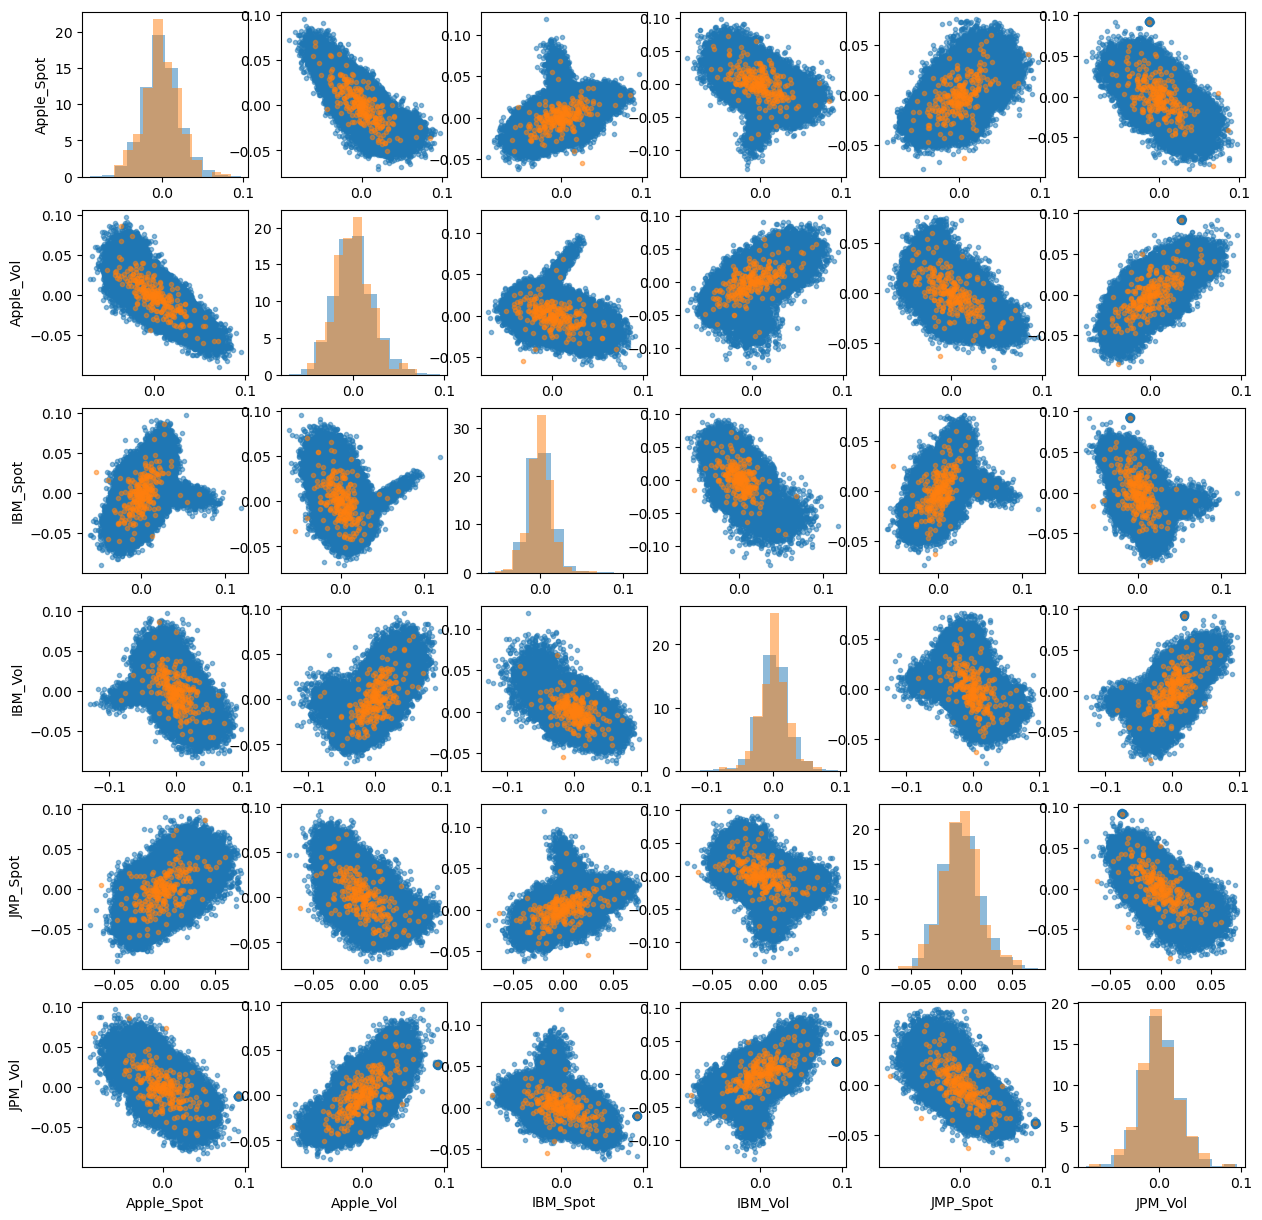

In [12]:
Miscellanea.plot_schocks(6,[dict_1d_results['sim_scenario_shifts'], hist_schocks_1d.values],hist_schocks_1d.columns,12)   

### 10 days

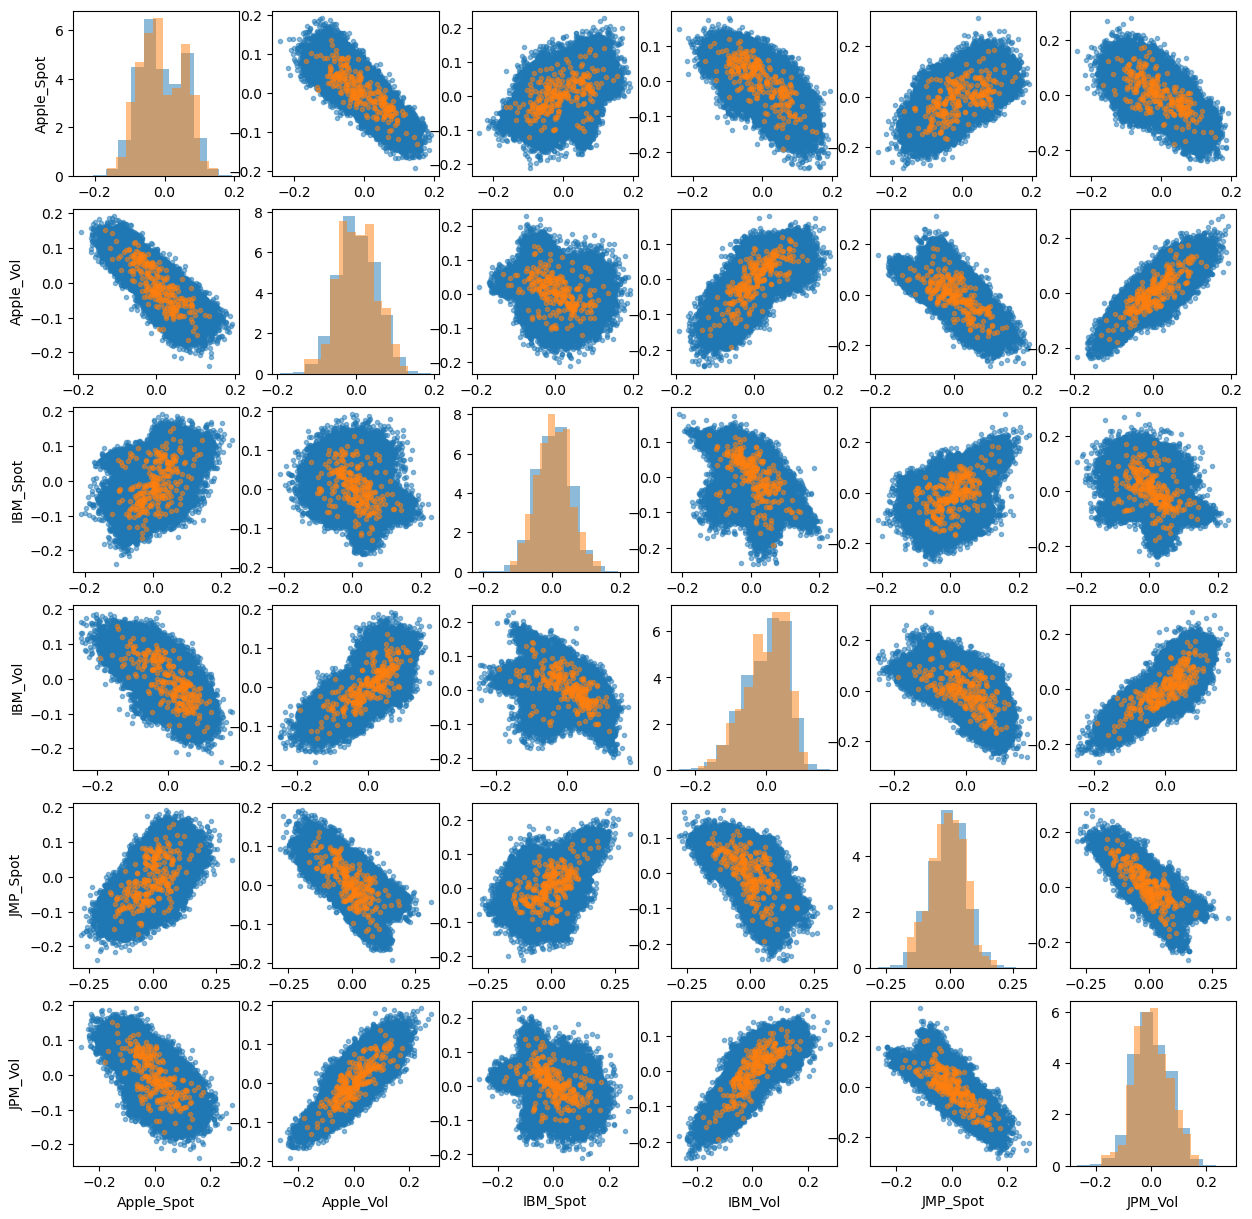

In [13]:
Miscellanea.plot_schocks(6,[dict_10d_results['sim_scenario_shifts'], hist_schocks_10d.values],hist_schocks_1d.columns,12)

### <span style="color:red">-----------------Train Models (beware of the options)---------------.</span>

### Models fitted to 10d data

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]

# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/MODELS_10D/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'

batch_size = 32
valid_data = None
epochs = 20

    
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_10d_results['sim_scenario_levels'][train_range], 
              dict_10d_results['payoff'][train_range],
              dict_10d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


### Models fitted to 1d data

In [ ]:
PATH_MODELS = 'MODELS/MODELS_1D/'

batch_size = 32
valid_data = None
epochs = 20
    
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_1d_results['sim_scenario_levels'][train_range], 
              dict_1d_results['payoff'][train_range],
              dict_1d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

### Models fitted to mixed data

In [ ]:
PATH_MODELS = 'MODELS/MODELS_MIXED/'

batch_size = 32
valid_data = None
epochs = 20
    
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train['sim_scenario_levels'][train_range], 
              dict_mixed_data_train['payoff'][train_range],
              dict_mixed_data_train['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

### <span style="color:red">-----------------End of model train---------------.</span>

### Load saved models

In [14]:
# PATH_MODELS = 'MODELS/MODELS_1D/'
# PATH_MODELS = 'MODELS/MODELS_10D/'
PATH_MODELS = 'MODELS/MODELS_MIXED/'


alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)



### Compute closed form formulas for different scenarios (inc base with sensitivities)

In [15]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

base_scenario = dict_1d_results['base_scenario']

if PATH_MODELS == 'MODELS/MODELS_1D/':
    rf_levels_sim = dict_1d_results['sim_scenario_levels']
    payoff_sim = dict_1d_results['payoff']
elif PATH_MODELS == 'MODELS/MODELS_10D/':
    rf_levels_sim = dict_10d_results['sim_scenario_levels']
    payoff_sim = dict_10d_results['payoff']
elif PATH_MODELS == 'MODELS/MODELS_MIXED/':
    rf_levels_sim = dict_mixed_data_train['sim_scenario_levels']
    payoff_sim = dict_mixed_data_train['payoff']
    
closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,                                                             
                rf_levels_sim[:,base_scenario_dict['spot_indexes']], 
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3), 
                rf_levels_sim[:,base_scenario_dict['vol_indexes']], 
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy() 

closed_form_hist_scenario_levels_1d = Option_formulas.BasketOptionVectorized(3,                                                             
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']], 
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3), 
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']], 
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy() 

closed_form_hist_scenario_levels_10d = Option_formulas.BasketOptionVectorized(3,                                                             
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']], 
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3), 
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']], 
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy() 


base_scenario_TF = tf.constant(dict_1d_results['base_scenario'])

with tf.GradientTape() as tape:

    tape.watch(base_scenario_TF)

    closed_form_base = Option_formulas.BasketOptionVectorized(3, 
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['spot_indexes']], 
            indiv_strikes, option_strike, base_scenario_dict['rfr'] * np.ones(3),
            base_scenario_dict['rfr'], base_scenario_dict['divs'] * np.ones(3), 
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['vol_indexes']],    
            np.array(base_scenario_dict['correlations']),
            contract_data_dict['ttm'] , True)


sens_base_scenario = tape.gradient(closed_form_base, base_scenario_TF).numpy()

closed_form_base = closed_form_base.numpy()[0]

### Compute bayes error

In [16]:
bayes_error_train = mean_squared_error(closed_form_sim_scenario_levels[train_range], 
                                          payoff_sim[train_range])

bayes_error_cv = mean_squared_error(closed_form_sim_scenario_levels[test_range], 
                                          payoff_sim[test_range])


print(bayes_error_train, bayes_error_cv)



0.047578523219908166 0.048972389613862605


### Compute metrics

In [134]:
BASE_SCEN_CTRL_VAR = False

    
closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base
    
if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = "NPV"
#     adjust_model_with_base_scenario = "NPV_plus_sens"
    
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = "No"
    

test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1), 
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]


    


metrics, best_model_metrics,best_model_zero_alpha_metrics = ModelHandlers.compute_model_metrics(
                    models, alphas, cells_layer, num_hidden_layers, 
                    rf_levels_sim[train_range], payoff_sim[train_range], 
                    rf_levels_sim[test_range], 
                    payoff_sim[test_range], 
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario);




KstestResult(statistic=0.236, pvalue=1.617774753768945e-06)

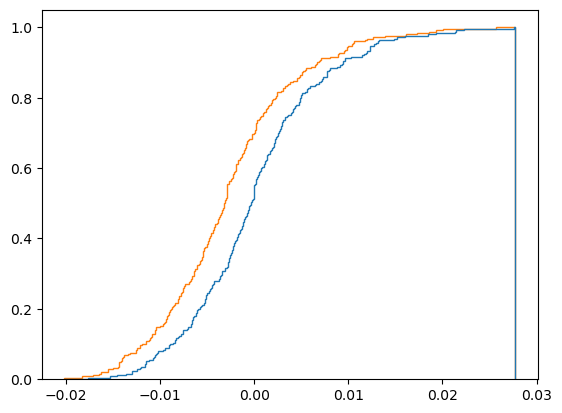

In [135]:
from scipy.stats import ks_2samp

xxx = best_model_metrics['cv_scenarios_closed_form1d']
yyy = best_model_metrics['cv_scenarios_model_results_plus_adjustments1d']

__, bins = np.histogram(xxx, bins=1000)
                        
plt.hist([xxx,yyy], density=True, histtype="step",cumulative=True, bins = 500) 

ks_2samp(xxx, yyy, mode = 'exact', alternative='two-sided')

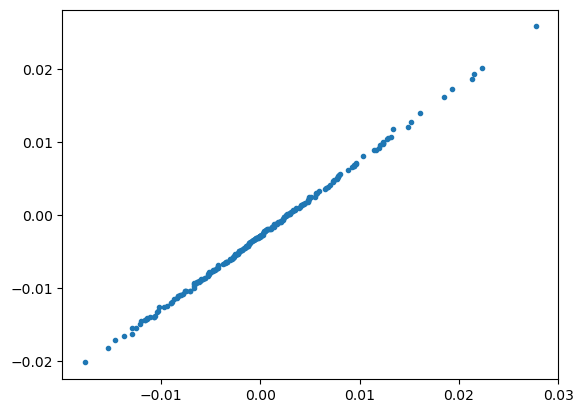

In [136]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

KstestResult(statistic=0.2, pvalue=8.65986462090846e-05)

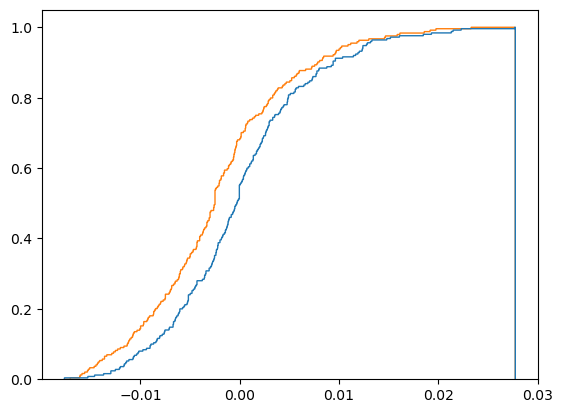

In [137]:

xxx = best_model_zero_alpha_metrics['cv_scenarios_closed_form1d']
yyy = best_model_zero_alpha_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins, density=True, histtype="step",cumulative=True)


ks_2samp(xxx, yyy, mode = 'exact')

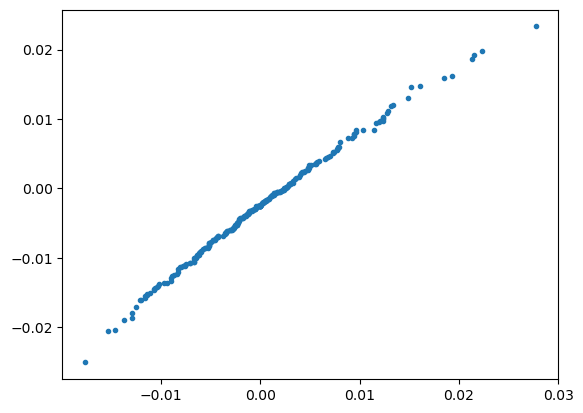

In [138]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

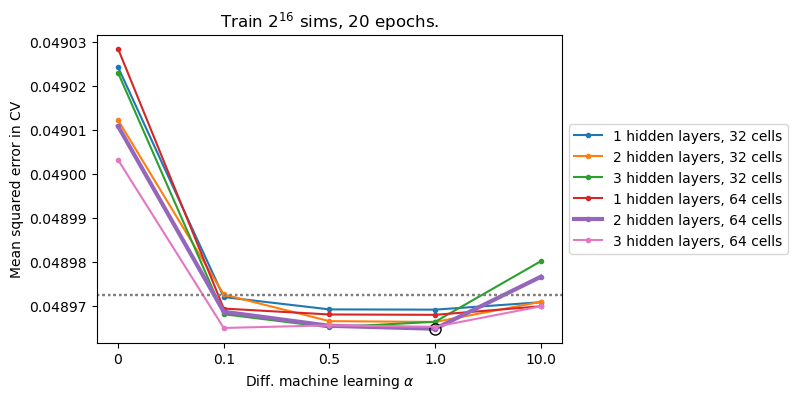

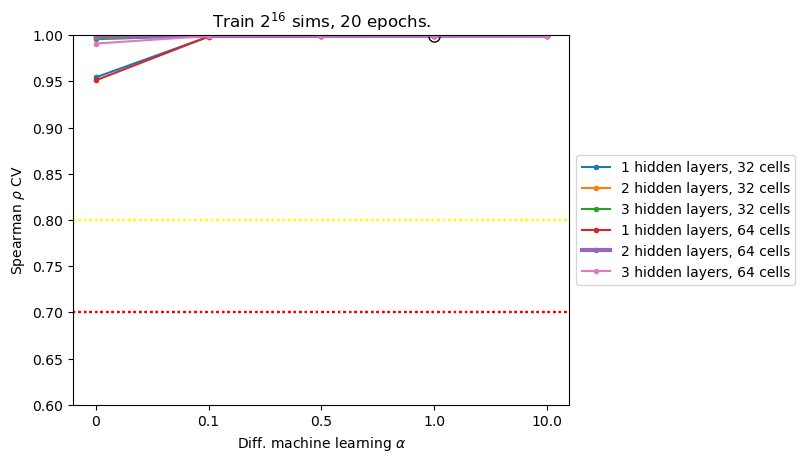

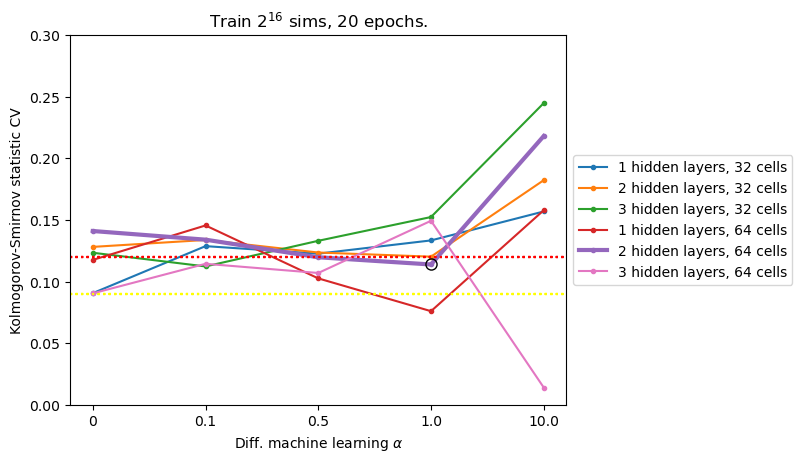

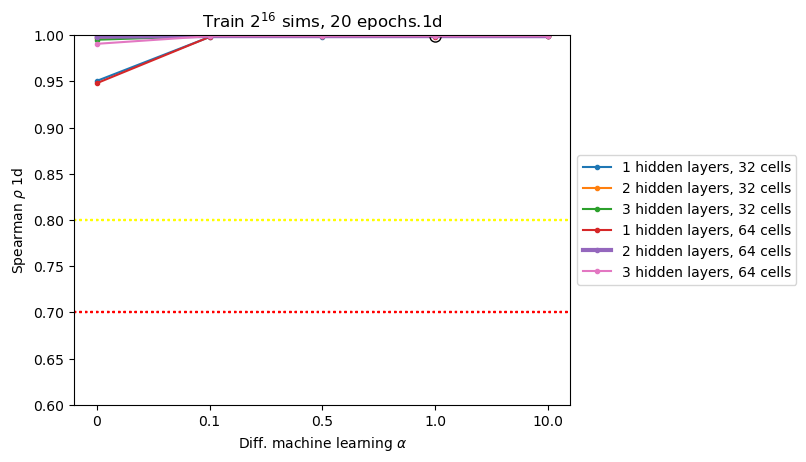

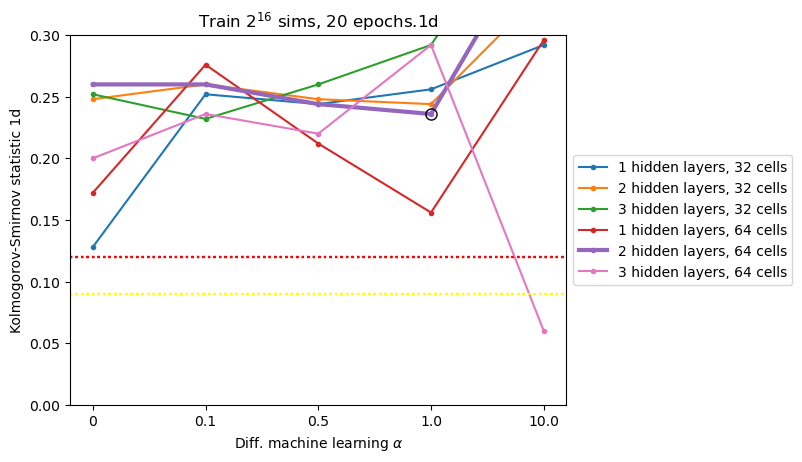

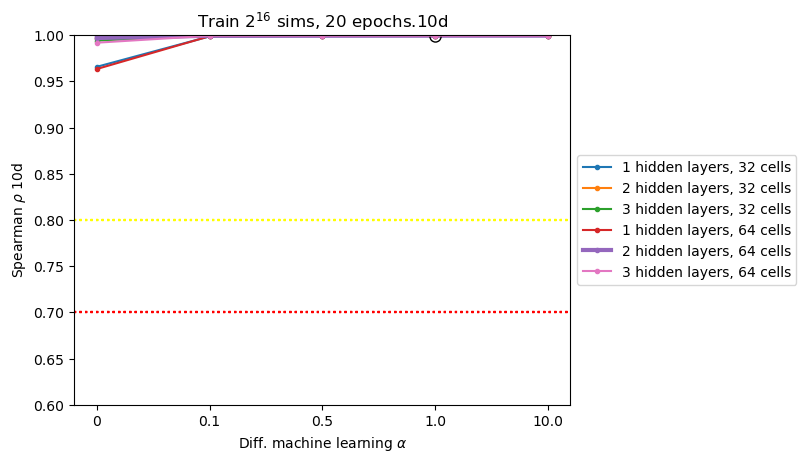

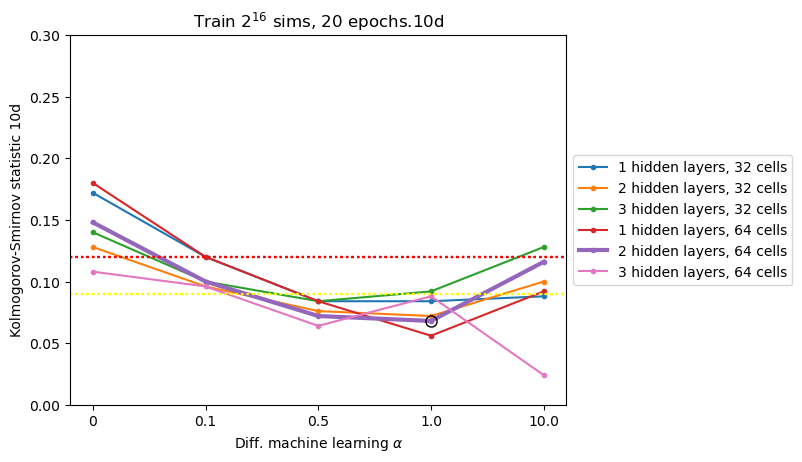

<Figure size 640x480 with 0 Axes>

In [139]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'


file_name = "CV_" + file_name 
    
ModelHandlers.plot_model_results(metrics, best_model_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Basket calcs

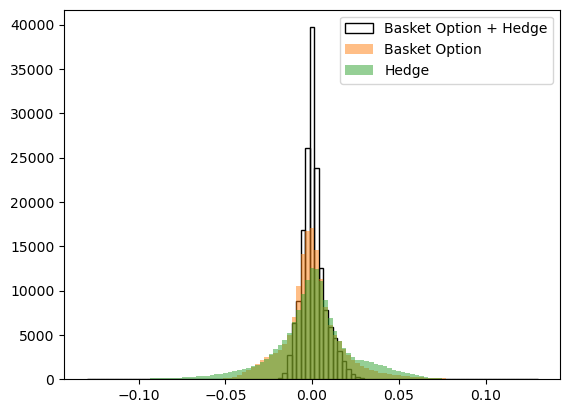

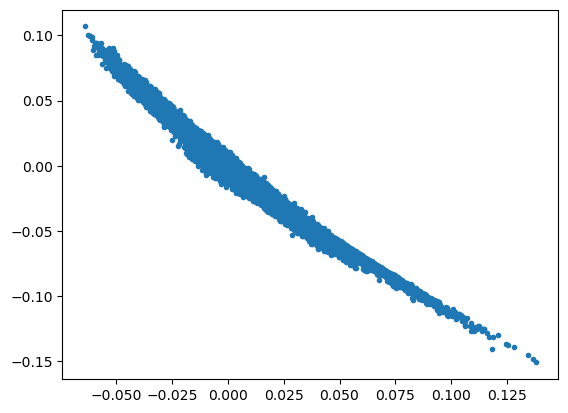

In [113]:
TTM_Hedge = contract_data_dict['ttm']


call_A = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][0]],
                                                        indiv_strikes[0] , TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'], 
                                                        MktData[:,base_scenario_dict['vol_indexes'][0]], True)
Fut_A = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][0]], indiv_strikes[0],
                                                 TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'])

call_B = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][1]],
                                                        indiv_strikes[1] , TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'], 
                                                        MktData[:,base_scenario_dict['vol_indexes'][1]], True)
Fut_B = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][1]], indiv_strikes[1],
                                                 TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'])

call_C = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][2]],
                                                        indiv_strikes[2] , TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'], 
                                                        MktData[:,base_scenario_dict['vol_indexes'][2]], True)
Fut_C = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][2]], indiv_strikes[2],
                                                 TTM_Hedge, base_scenario_dict['rfr'], 
                                                        base_scenario_dict['divs'])



exot = lambda MktData: Option_formulas.BasketOptionVectorized(3, MktData[:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                  base_scenario_dict['rfr']*np.ones(3), base_scenario_dict['rfr'], 
                  base_scenario_dict['divs']*np.ones(3), 
                  MktData[:,base_scenario_dict['vol_indexes']], base_scenario_dict['correlations'],
                  contract_data_dict['ttm'], True) 

basket_elements = [Fut_A, call_A, Fut_B, call_B, Fut_C, call_C]

my_basket = Option_formulas.Basket(basket_elements, exot)

my_basket.compute_hedge(base_scenario)


bins = np.linspace(-0.13,0.13,100)

plt.hist((exot(rf_levels_sim).numpy()-exot(base_scenario.reshape(1,-1)).numpy())
         +(my_basket.value_basket(rf_levels_sim)-my_basket.value_basket(base_scenario)), bins = bins, alpha = 1.0, facecolor = 'None',
         edgecolor= 'black',label = 'Basket Option + Hedge');

plt.hist(exot(rf_levels_sim).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), bins = bins, alpha = 0.5, label = "Basket Option")

plt.hist(my_basket.value_basket(rf_levels_sim)-my_basket.value_basket(base_scenario), bins=bins, alpha = 0.5, label = 'Hedge');


plt.legend()
plt.savefig(PATH_FIGS + 'hedge_histogram.pdf')
plt.figure()



plt.plot(exot(rf_levels_sim).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), my_basket.value_basket(rf_levels_sim)-my_basket.value_basket(base_scenario), '.')

In [114]:
basket_base = my_basket.value_basket(base_scenario)

basket_sim_data_PL_inc = my_basket.value_basket(rf_levels_sim) - basket_base

basket_1d_PL_inc = my_basket.value_basket(dict_1d_results['hist_scenario_levels']) - basket_base

basket_10d_PL_inc = my_basket.value_basket(dict_10d_results['hist_scenario_levels']) - basket_base


In [115]:
basket_sim_data_PL_inc

array([-0.01017762,  0.01160353, -0.01928928, ..., -0.00561593,
        0.01604573,  0.01395418])

### Compute metrics with hedge basket

In [130]:
BASE_SCEN_CTRL_VAR = False


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    basket_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = "NPV"
    adjust_model_with_base_scenario = "NPV_plus_sens"
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = "No"


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1), 
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + basket_1d_PL_inc,
                     'model_adj': model_adj_test + basket_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + basket_10d_PL_inc,
                     'model_adj': model_adj_test + basket_10d_PL_inc}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    rf_levels_sim[train_range], payoff_sim[train_range], rf_levels_sim[test_range], payoff_sim[test_range], 
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + basket_sim_data_PL_inc[train_range],
                    model_adj_test + basket_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)




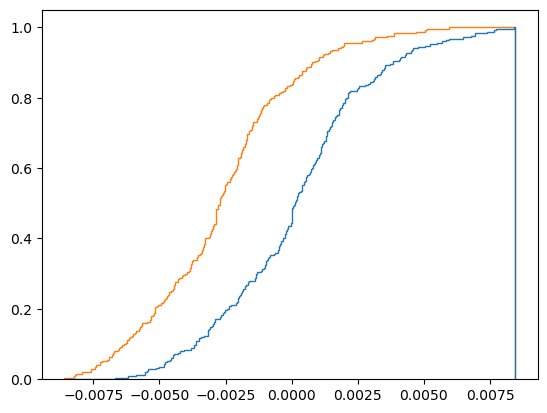

In [131]:
xxx = best_model_metrics['cv_scenarios_closed_form1d']
yyy = best_model_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins = 500,density=True,cumulative=True,histtype = 'step');


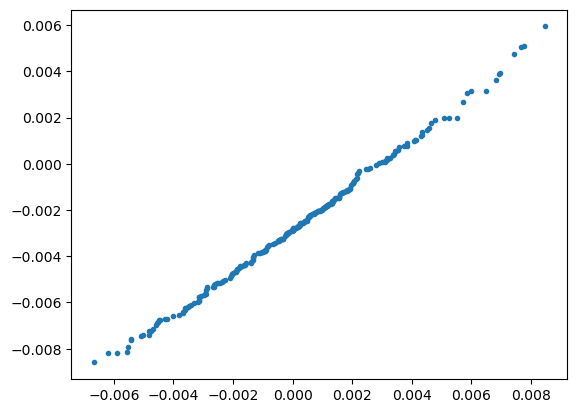

In [132]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

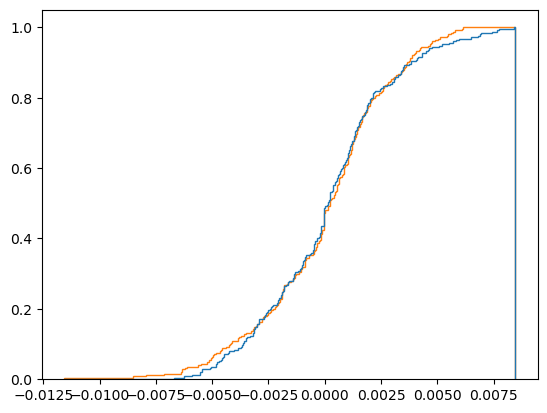

In [126]:
xxx = best_model_zero_alpha_metrics['cv_scenarios_closed_form1d']
yyy = best_model_zero_alpha_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins = 500,density=True,cumulative=True,histtype = 'step');

array([[1.        , 0.98357696],
       [0.98357696, 1.        ]])

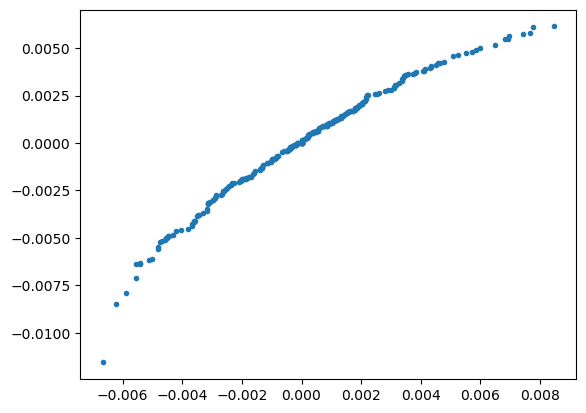

In [129]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

np.corrcoef(np.sort(xxx),np.sort(yyy))

In [ ]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'Hedge_' + file_name 
    
ModelHandlers.plot_model_results(metrics, best_model_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Simulation of scenarios computing variance reduction

In [141]:
simulation_dict['Simulate_Var_Red_Payoff'] = Scenario_Simulation.Simulate_Var_Red_Payoff.YES


gaussian_model_dict['gaussian_model_seed'] = 1234
simulation_dict['simulation_seed'] = 5678

dict_1d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.values)



gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321



dict_10d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

dict_1d_results_train = {k:dict_1d_results_VR[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results_VR[k] for k in train_data_keys}


dict_mixed_data_train_VR = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train





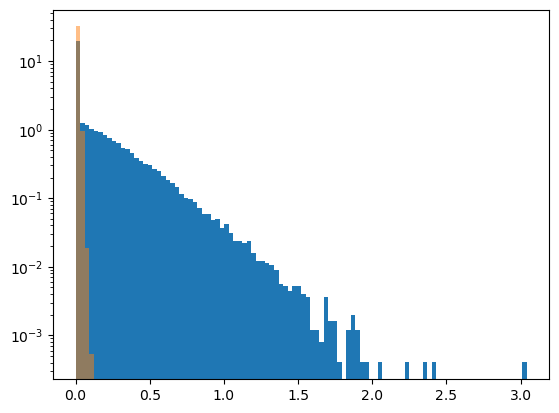

In [142]:

lll = np.histogram(dict_1d_results['payoff'], bins = 100)

plt.hist(dict_1d_results['payoff'], bins = lll[1], density = True);

plt.hist(dict_1d_results_VR['payoff'], bins = lll[1], density = True, alpha = 0.5);
plt.yscale('log');


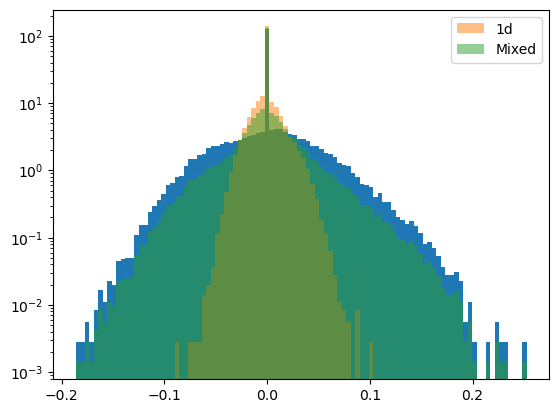

In [143]:
lll = np.histogram(dict_10d_results_VR['payoff'], bins = 100)

plt.hist(dict_10d_results_VR['payoff'], bins = lll[1], density = True);
plt.hist(dict_1d_results_VR['payoff'], bins = lll[1], density = True, alpha = 0.5, label = '1d');
plt.hist(dict_mixed_data_train_VR['payoff'], bins = lll[1], density = True, alpha = 0.5, label = 'Mixed');

plt.legend()
plt.yscale('log');


### <span style="color:red">-----------------Train Models VR (beware of the options)---------------.</span>

## Models fitted to mixed data

In [144]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]


PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'


batch_size = 32
valid_data = None
epochs = 20

    
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train_VR['sim_scenario_levels'][train_range], 
              dict_mixed_data_train_VR['payoff'][train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


The folder 'MODELS_VR/MODELS_MIXED/' exists. Do you want to delete its contents? (y/n)n
The contents of the folder 'MODELS_VR/MODELS_MIXED/' were not deleted.
FITTING MODEL: alpha: 0, cells: 32, num_hidden: 1


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'MODELS_VR/MODELS_MIXED/alpha_0_cells_32_hidden_1/'

### Load models data for variance reduction

In [179]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)


if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    rf_levels_sim = dict_1d_results['sim_scenario_levels']
    payoff_sim = dict_1d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    rf_levels_sim = dict_10d_results['sim_scenario_levels']
    payoff_sim = dict_10d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    rf_levels_sim = dict_mixed_data_train['sim_scenario_levels']
    payoff_sim = dict_mixed_data_train['payoff']
    
closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,                                                             
                rf_levels_sim[:,base_scenario_dict['spot_indexes']], 
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3), 
                rf_levels_sim[:,base_scenario_dict['vol_indexes']], 
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy() 

### Compute metrics (no hedge)

In [162]:
BASE_SCEN_CTRL_VAR = True



closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = 'NPV'
    adjust_model_with_base_scenario = "NPV_plus_sens"
else:
    model_adj_train = - 0
    model_adj_cv = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = 'No'


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1), 
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]


metrics, best_model_metrics, best_model_zero_alpha_metrics = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    rf_levels_sim[train_range], payoff_sim[train_range], 
                    rf_levels_sim[test_range], 
                    payoff_sim[test_range], 
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario)



# Plot charts (no hedge)

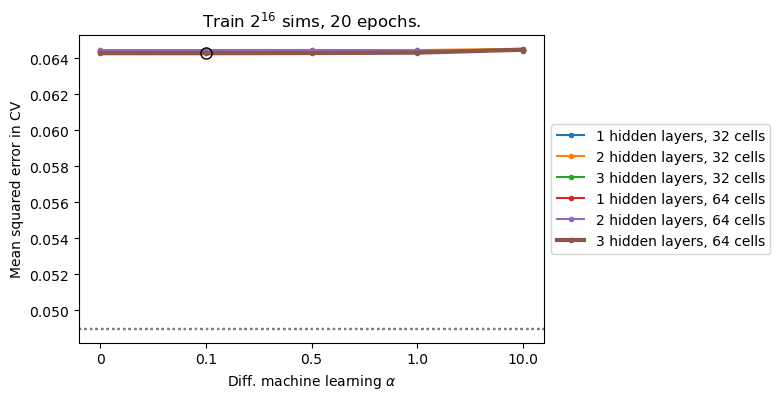

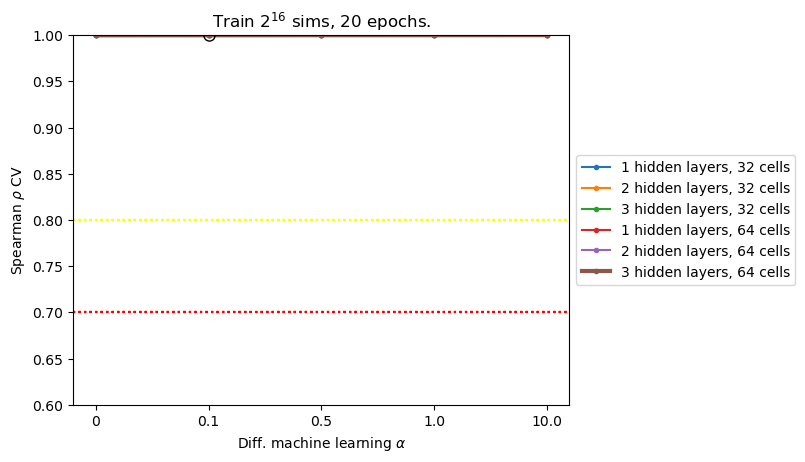

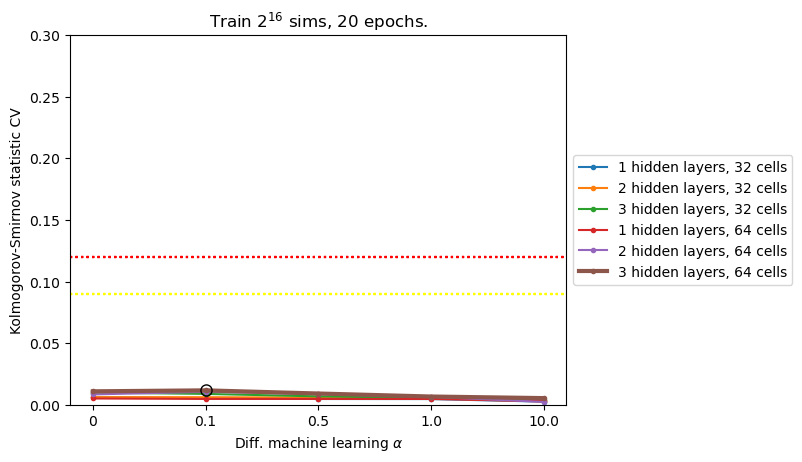

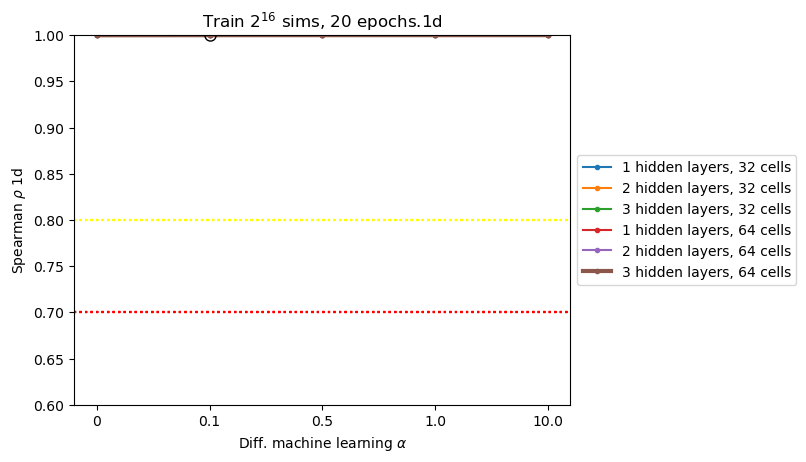

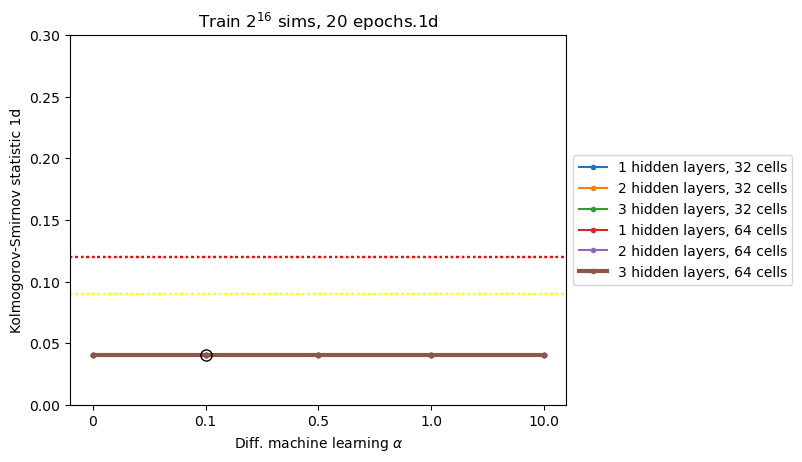

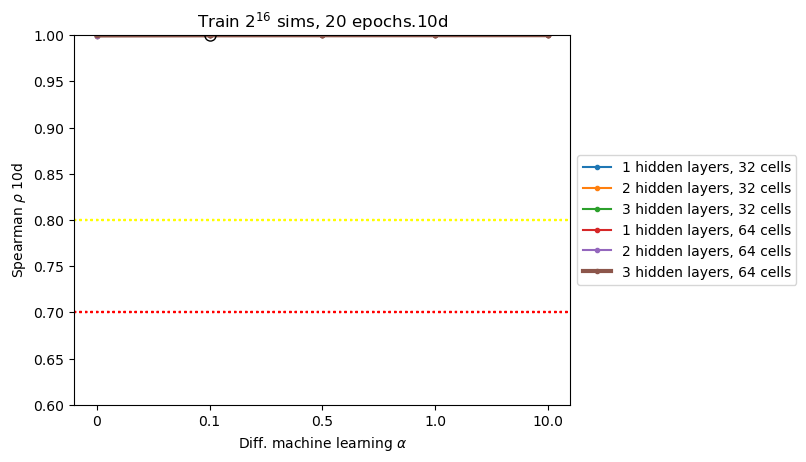

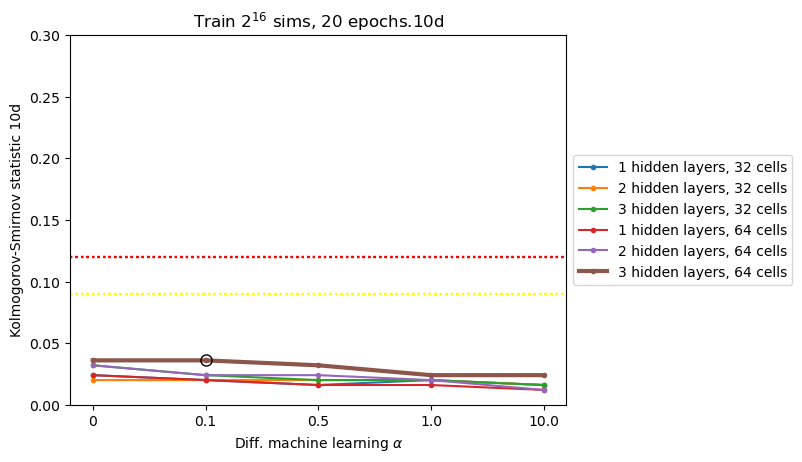

<Figure size 640x480 with 0 Axes>

In [163]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name  
    
ModelHandlers.plot_model_results(metrics,best_model_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

(array([[0.004, 0.004, 0.004, ..., 0.996, 0.996, 1.   ],
        [0.   , 0.   , 0.   , ..., 1.   , 1.   , 1.   ]]),
 array([-0.0176452 , -0.01759982, -0.01755444, ...,  0.02764798,
         0.02769337,  0.02773875]),
 <a list of 2 list[Polygon] objects>)

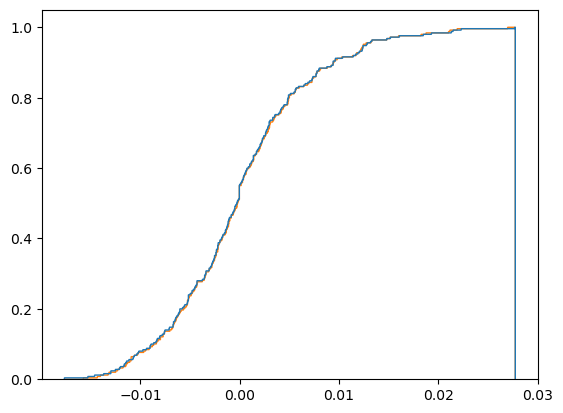

In [164]:
xxx = best_model_zero_alpha_metrics['cv_scenarios_closed_form1d']
yyy = best_model_zero_alpha_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins, density=True, histtype="step",cumulative=True)

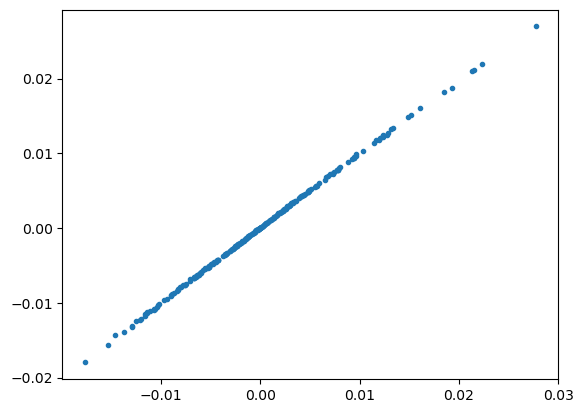

In [165]:

plt.plot(np.sort(xxx),np.sort(yyy), '.') 

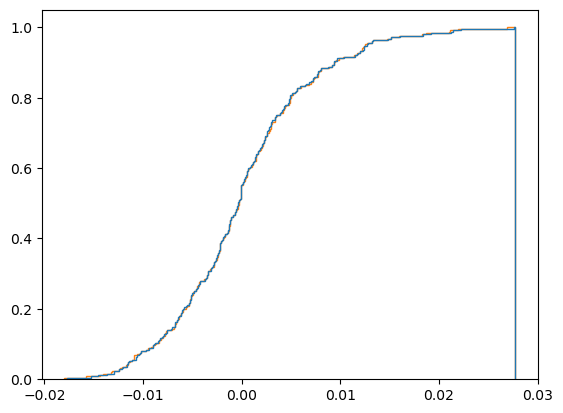

In [166]:

xxx = best_model_zero_alpha_metrics['cv_scenarios_closed_form1d']
yyy = best_model_zero_alpha_metrics['cv_scenarios_model_results_plus_adjustments1d']

plt.hist([xxx,yyy], bins = 500,density=True,cumulative=True,histtype = 'step');

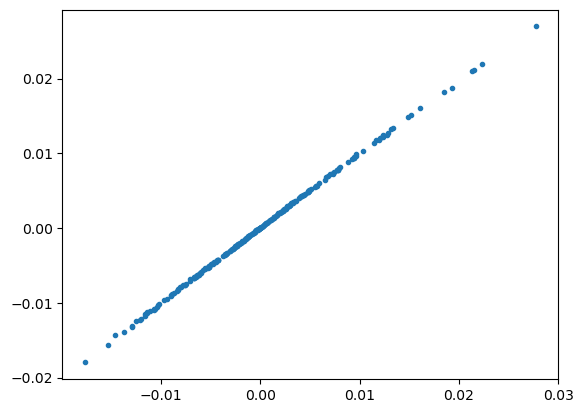

In [167]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

### Compute metrics (hedge)

In [180]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    basket_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = "NPV"
#     adjust_model_with_base_scenario = "NPV_plus_sens"
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = "No"


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1), 
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + basket_1d_PL_inc,
                     'model_adj': model_adj_test + basket_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'], 
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + basket_10d_PL_inc,
                     'model_adj': model_adj_test + basket_10d_PL_inc}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    rf_levels_sim[train_range], payoff_sim[train_range], rf_levels_sim[test_range], payoff_sim[test_range], 
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + basket_sim_data_PL_inc[train_range],
                    model_adj_test + basket_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

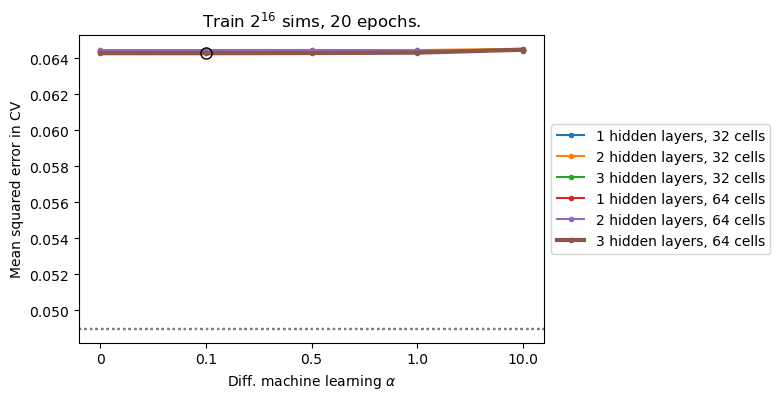

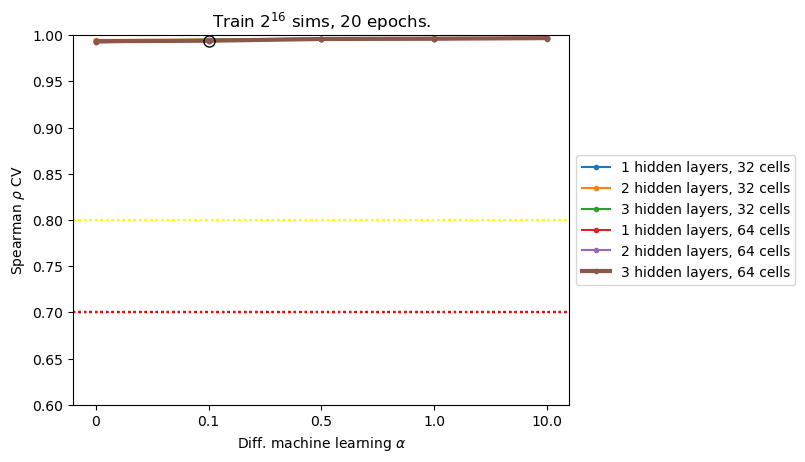

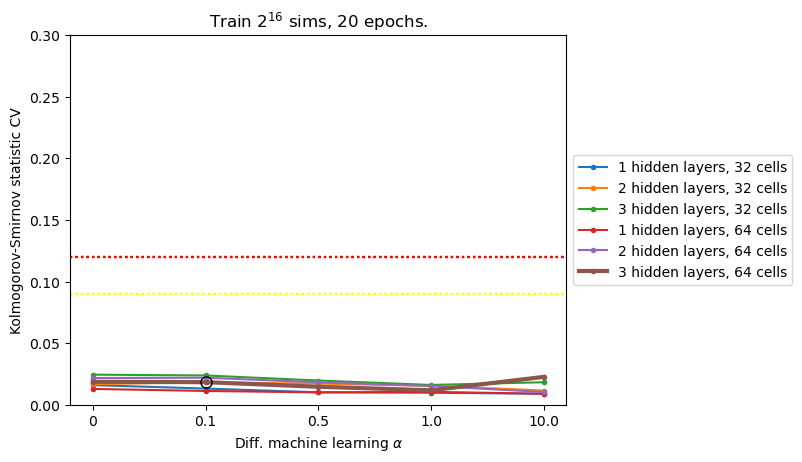

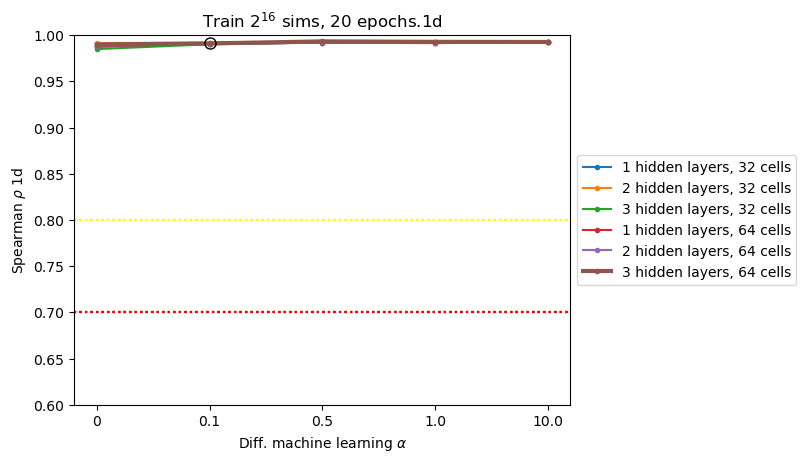

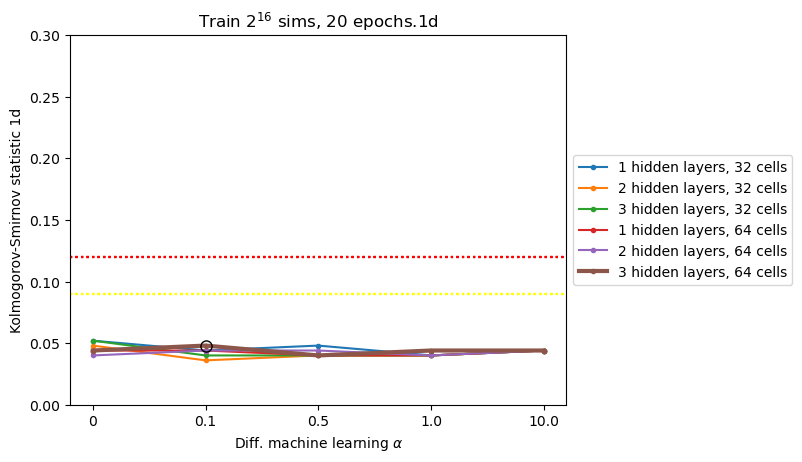

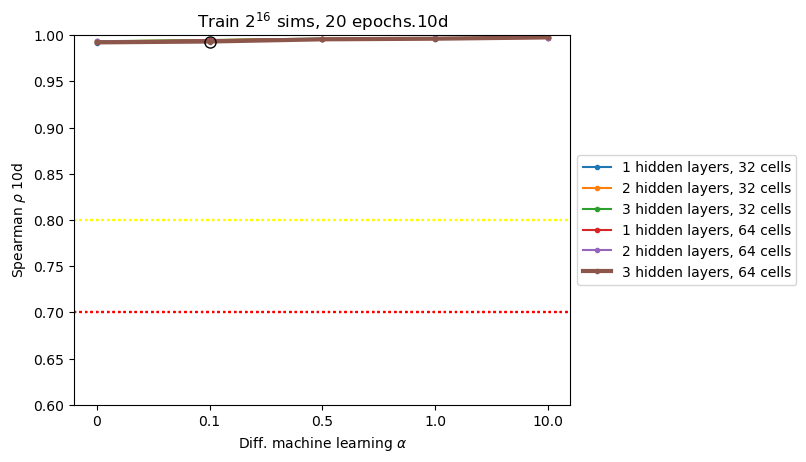

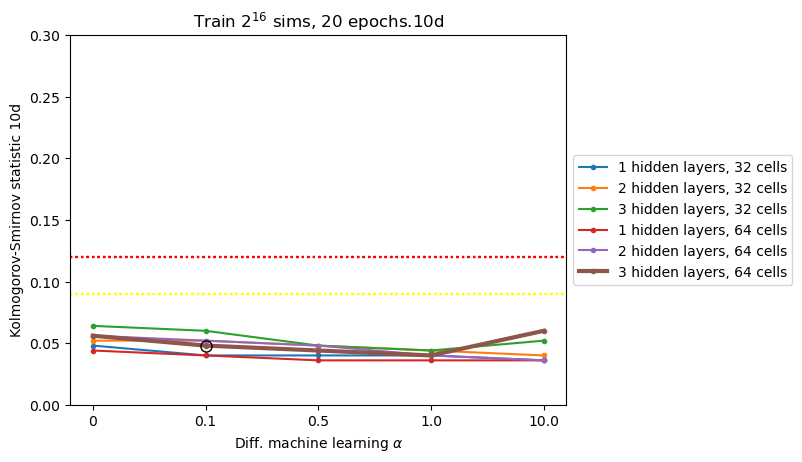

<Figure size 640x480 with 0 Axes>

In [181]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name  
    
ModelHandlers.plot_model_results(metrics,best_model_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

(array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]),
 array([-0.0176452 , -0.01759982, -0.01755444, ...,  0.02764798,
         0.02769337,  0.02773875]),
 <a list of 2 list[Polygon] objects>)

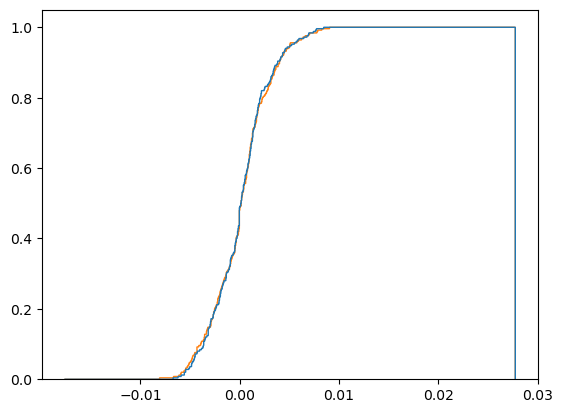

In [182]:
xxx = best_model_metrics['cv_scenarios_closed_form1d']
yyy = best_model_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins, density=True, histtype="step",cumulative=True)


In [ ]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 

In [ ]:
xxx = best_model_zero_alpha_metrics['cv_scenarios_closed_form1d']
yyy = best_model_zero_alpha_metrics['cv_scenarios_model_results_plus_adjustments1d']

                        
plt.hist([xxx,yyy], bins = 500,density=True,cumulative=True,histtype = 'step');

In [ ]:
plt.plot(np.sort(xxx),np.sort(yyy), '.') 